In [26]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

sns.set(style="whitegrid")

In [27]:
# Upload File
from google.colab import files
uploaded = files.upload()

Saving istanbul_metro_monthly_all_lines_with_tram_funicular.csv to istanbul_metro_monthly_all_lines_with_tram_funicular (1).csv


In [28]:
# Load Data
df = pd.read_csv("istanbul_metro_monthly_all_lines_with_tram_funicular.csv")
df.head()

,Year,Month,Metro Line,Passengers
0,2019,April,M1,12739273
1,2019,August,M1,10951303
2,2019,December,M1,13077123
3,2019,February,M1,11858209
4,2019,January,M1,12672664


In [29]:
 # Clean and Prepare
df['Month'] = pd.Categorical(df['Month'], categories=[
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
], ordered=True)
df = df.sort_values(by=["Year", "Month"])

<ipython-input-30-84e981fa9c93>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_totals = df.groupby(["Year", "Month"])["Passengers"].sum().reset_index()


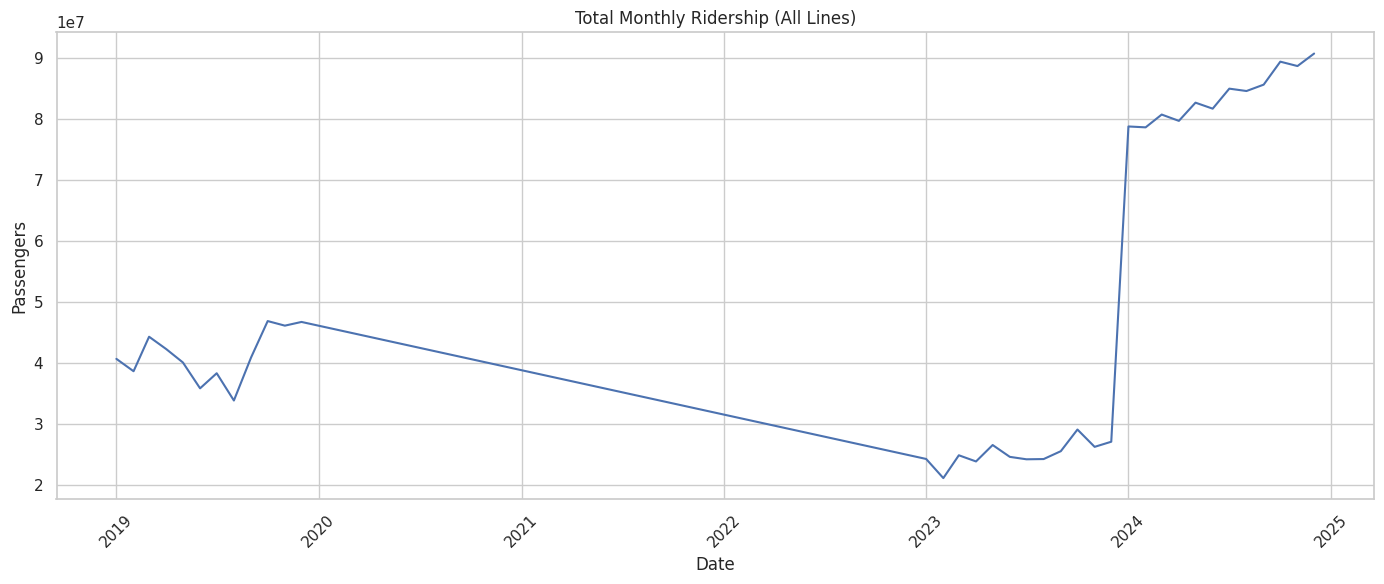

In [30]:
# Total Monthly Ridership Over Time
plt.figure(figsize=(14, 6))
monthly_totals = df.groupby(["Year", "Month"])["Passengers"].sum().reset_index()
monthly_totals["Date"] = monthly_totals["Year"].astype(str) + "-" + monthly_totals["Month"].astype(str)
monthly_totals["Date"] = pd.to_datetime(monthly_totals["Date"], format="%Y-%B")
sns.lineplot(data=monthly_totals, x="Date", y="Passengers")
plt.title("Total Monthly Ridership (All Lines)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-31-230491e505c8>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df[df["Year"] == 2024], x="Metro Line", y="Passengers", estimator=sum, ci=None)


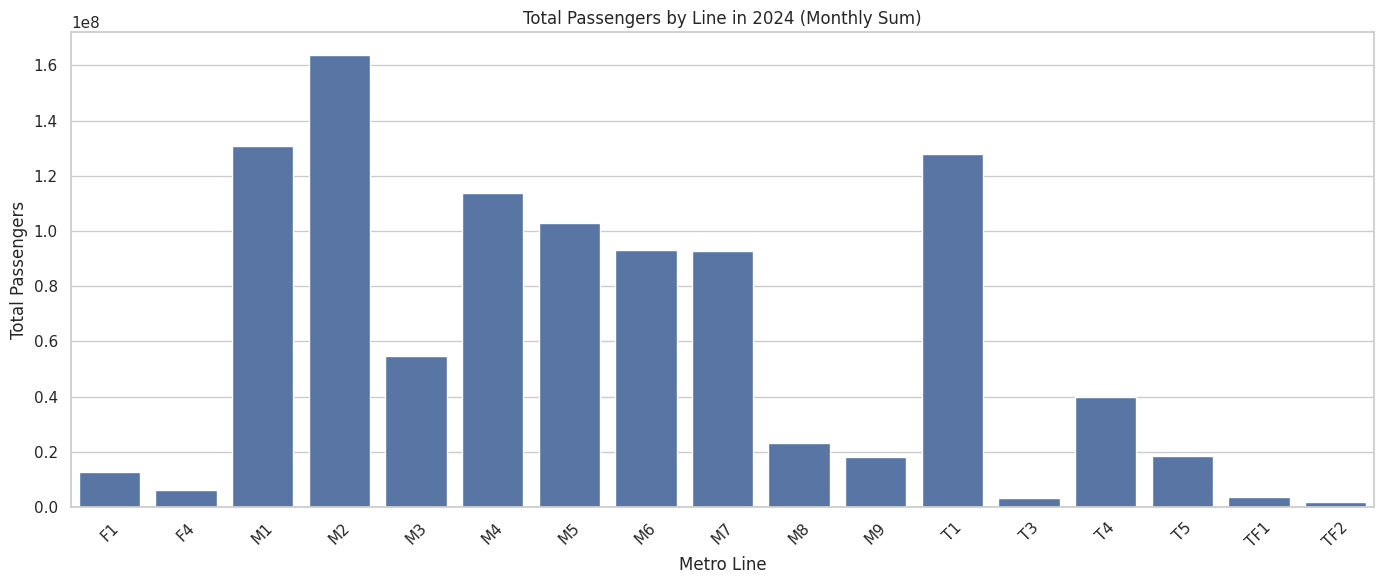

In [31]:
# Monthly Breakdown by Line (2024 Example)
plt.figure(figsize=(14, 6))
sns.barplot(data=df[df["Year"] == 2024], x="Metro Line", y="Passengers", estimator=sum, ci=None)
plt.title("Total Passengers by Line in 2024 (Monthly Sum)")
plt.ylabel("Total Passengers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

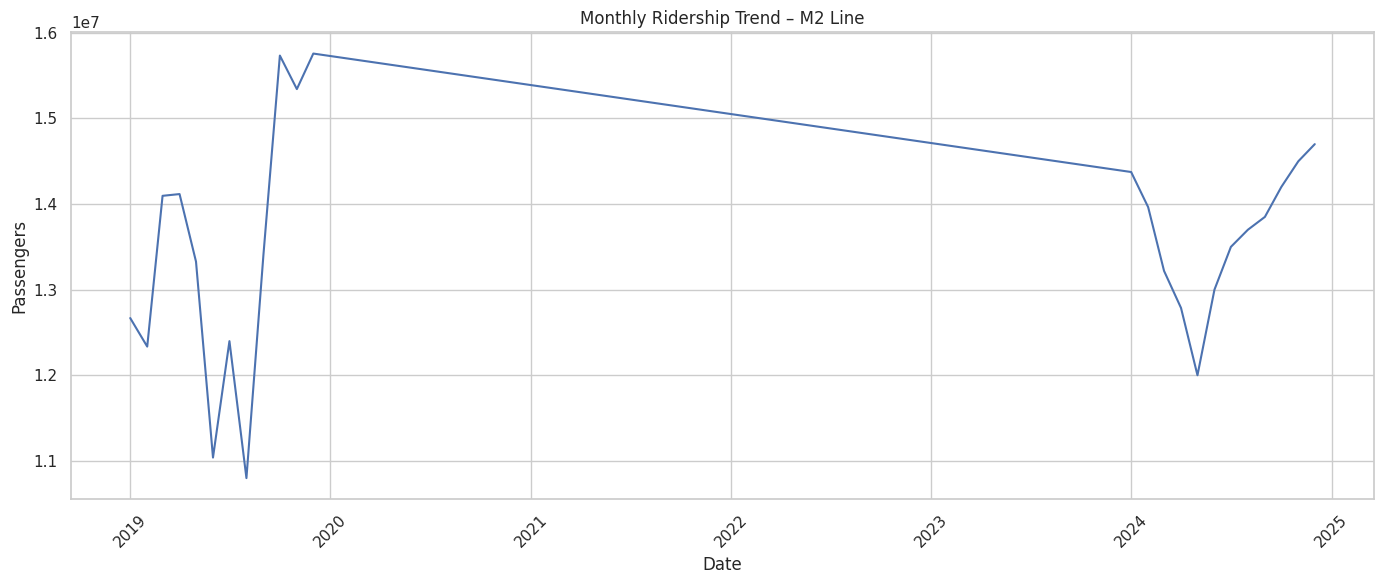

In [32]:
# Line-specific Trend: Example for M2
plt.figure(figsize=(14, 6))
m2_data = df[df["Metro Line"] == "M2"].copy()
m2_data["Date"] = m2_data["Year"].astype(str) + "-" + m2_data["Month"].astype(str)
m2_data["Date"] = pd.to_datetime(m2_data["Date"], format="%Y-%B")
sns.lineplot(data=m2_data, x="Date", y="Passengers")
plt.title("Monthly Ridership Trend – M2 Line")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
# Hypothesis Test
#General Function for Monthly T-Test
def compare_monthly_ridership(line, year1, year2):

  data1 = df[(df["Metro Line"] == line) & (df["Year"] == year1)]["Passengers"]
  data2 = df[(df["Metro Line"] == line) & (df["Year"] == year2)]["Passengers"]

  if len(data1) < 2 or len(data2) < 2:
      print(f"🚫 Not enough data for t-test on line {line} between {year1} and {year2}")
      return

  t_stat, p_val = ttest_ind(data1, data2)

  print(f"📊 Monthly T-Test for {line}: {year2} vs {year1}")
  print(f"T-statistic: {t_stat:.4f}")
  print(f"P-value: {p_val:.4f}")

  if p_val < 0.05:
      print("🚨 Significant difference in average monthly ridership.")
  else:
      print("✅ No statistically significant difference.")

# Example usage:
compare_monthly_ridership("M2", 2019, 2024)


📊 Monthly T-Test for M2: 2024 vs 2019
T-statistic: -0.4325
P-value: 0.6696
✅ No statistically significant difference.


### Hypothesis Test: M2 Monthly Ridership (2019 vs 2024)

**Null Hypothesis (H₀):**There is no difference in average monthly ridership of M2 between 2019 and 2024.  
**Alternative Hypothesis (H₁):** There is a significant difference in average monthly ridership of M2 between 2019 and 2024.

Using a two-sample t-test on monthly data, we obtained a **p-value of 0.6696**.  
Since this value is greater than the significance level of 0.05, we **fail to reject the null hypothesis**.  
This means there is **no statistically significant change** in average monthly ridership on the M2 line between 2019 and 2024.

In [36]:
compare_monthly_ridership("M7", 2023, 2024)

📊 Monthly T-Test for M7: 2024 vs 2023
T-statistic: -4.4747
P-value: 0.0002
🚨 Significant difference in average monthly ridership.


In [37]:
compare_monthly_ridership("T5", 2023, 2024)

📊 Monthly T-Test for T5: 2024 vs 2023
T-statistic: -7.0221
P-value: 0.0000
🚨 Significant difference in average monthly ridership.
